## What we need 

Get data from WRDS --> is this through openAP

get fama french factors? 

How do we get the long-short positions?? like how do we see the returns?

are we able to get wrds connection or should we get a file downloaded from you 

will we be able to use gridsearchCV to run multiple models at once?

In [2]:
DEV = True # will shrink datasets after loading


In [3]:
import pandas as pd
import polars as pl

import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
crsp = pd.read_csv('crsp_data.csv')
crsp.info()

# for speedy dev, pick 20 permnos at random (with seed)
if DEV:
    np.random.seed(123)
    permnos = crsp['permno'].unique()
    permnos = np.random.choice(permnos, size=20, replace=False)
    crsp = crsp[crsp['permno'].isin(permnos)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4047630 entries, 0 to 4047629
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   permno  int64  
 1   date    object 
 2   ret     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 92.6+ MB


In [5]:
# crsp = pl.from_pandas(crsp)

crsp['date'] = pd.to_datetime(crsp['date'])

cleancrsp = crsp.query('ret.notnull() and date.dt.year >= 1975')
#crsp["ret"].is_not_null(), crsp['date'].dt.year() >= 1975) 
# keep only the data that has return and after 1975

len(cleancrsp['ret'].notnull()) # check that no null values in ret
len(cleancrsp['ret'].notnull()) == len(cleancrsp) # check that all ret values are not null

cleancrsp


,permno,date,ret
29180,10181,1986-05-30,6.8493
29181,10181,1986-06-30,16.6667
29182,10181,1986-07-31,1.0989
29183,10181,1986-08-29,-6.5217
29184,10181,1986-09-30,-4.6512
...,...,...,...
4037917,93235,2014-04-30,17.2319
4037918,93235,2014-05-30,-1.3066
4037919,93235,2014-06-30,5.7683
4037920,93235,2014-07-31,-2.9951


In [5]:
max_idx = cleancrsp['ret'].argmax()

cleancrsp.iloc[max_idx-5:max_idx+5] # this seems like an outlier for sure, not to be included in the data --> company is black stone minerals. 

,permno,date,ret
1789840,42076,1975-06-30,0.0000
1789841,42076,1975-07-31,8.3333
1789842,42076,1975-08-29,0.0000
1789843,42076,1975-09-30,-15.3846
1789844,42076,1975-10-31,-9.0909
2352007,61241,1975-01-31,147.0588
2352008,61241,1975-02-28,21.4286
2352009,61241,1975-03-31,33.3333
2352010,61241,1975-04-30,2.9412
2352011,61241,1975-05-30,31.4286


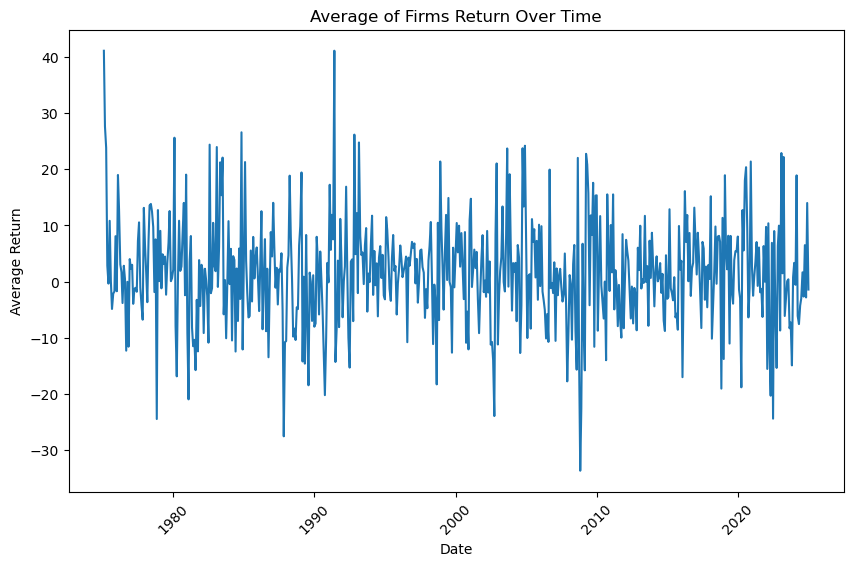

In [6]:
# Exploratory Data Analysis (EDA) on the returns data looking at the average market return per year
plt.figure(figsize=(10, 6))
sns.lineplot(data=cleancrsp, x='date', y='ret', ci=None)
plt.title('Average of Firms Return Over Time')
plt.xlabel('Date')
plt.ylabel('Average Return')
plt.xticks(rotation=45)
plt.show()


In [7]:
cleancrsp['ret'].describe(percentiles=[.01, .05, .10, .25, .5, .75, .9, .95, .99, .995]) # check the distribution of returns

count    2497.000000
mean        1.613311
std        15.738224
min       -66.573800
1%        -36.856788
5%        -21.481520
10%       -14.941300
25%        -6.060600
50%         0.539100
75%         7.337300
90%        17.835280
95%        26.547200
99%        53.333592
99.5%      63.974036
max       147.058800
Name: ret, dtype: float64

In [8]:
cleancrsp['permno'].nunique() # check the number of unique permnos

cleancrsp['permno'].value_counts()


# profile = ProfileReport(cleancrsp, title="CRSP Data Profiling Report")


permno
61241    600
78837    333
87666    297
69060    206
17340    169
90316    154
14985    122
78850    111
79404    110
77652     79
40934     72
93235     55
28338     54
10181     46
21538     38
86096     27
24482     14
42076     10
Name: count, dtype: int64

In [41]:
# profile

In [7]:
import pandas_datareader as pdr
# load Fama-French factors

start = '1975-01-01'
start_date = datetime.strptime(start, '%Y-%m-%d')

# load Fama-French 5 factors
ff_5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start=start_date)[0]
ff_mom = pdr.get_data_famafrench('F-F_Momentum_Factor', start=start_date)[0]

# # load Fama-French factors
# df_factors = pdr.ff.FamaFrenchReader('F-F_Research_Data_5_Factors_2x3', start='1975-01-01').read()[0]

# # add momentum to this

ff_mom.columns = ['Mom'] # rename
ff_mom
ff_factors = pd.merge(ff_5, ff_mom, left_index=True, right_index=True)
# df_factors # FYI: contains Mkt-RF and RF, but no Mkt
#


In [8]:
ff_factors = ff_factors.reset_index().rename(columns={"Mkt-RF":"mkt_excess", "Date":"date"})

ff_factors
ff_factors["date"] = ff_factors["date"].dt.to_timestamp()

ff_factors["date"] = ff_factors["date"].apply(lambda x: x.replace(day=28))

# # # Then add the month offset
ff_factors["date"] = ff_factors["date"] + pd.DateOffset(months=1)

ff_factors
## will need to lag the signals and put the date to 28

,date,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,1975-02-28,13.66,12.91,8.28,-0.78,-0.90,0.58,-13.82
1,1975-03-28,5.56,-0.65,-4.45,1.16,-2.11,0.43,-0.61
2,1975-04-28,2.66,4.00,2.38,1.26,-1.33,0.41,-2.04
3,1975-05-28,4.23,-0.71,-1.14,1.41,-1.34,0.44,1.38
4,1975-06-28,5.19,2.89,-4.10,-0.98,-0.60,0.44,-0.58
...,...,...,...,...,...,...,...,...
595,2024-09-28,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79
596,2024-10-28,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60
597,2024-11-28,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87
598,2024-12-28,6.51,4.78,-0.05,-2.62,-2.17,0.40,0.90


## Open Signals from Zip

In [9]:
from zipfile import ZipFile


def open_dataframe_from_zip(zip_filepath, csv_filename):
    """
    Opens a Pandas DataFrame from a CSV file within a zip archive.

    Args:
        zip_filepath (str): Path to the zip file.
        csv_filename (str): Name of the CSV file inside the zip archive.

    Returns:
        pandas.DataFrame: The DataFrame read from the CSV file, or None if an error occurs.
    """
    try:
        with ZipFile(zip_filepath) as zf:
            with zf.open(csv_filename) as csvf:
                df = pd.read_csv(csvf)
        return df
    except FileNotFoundError:
        print(f"Error: Zip file not found at '{zip_filepath}'")
        return None
    except KeyError:
        print(f"Error: CSV file '{csv_filename}' not found in the zip archive.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example usage:
if DEV == False:
    zip_filepath = 'signed_predictors_dl_wide.zip'
    csv_filename = 'signed_predictors_dl_wide.csv'
    signals = open_dataframe_from_zip(zip_filepath, csv_filename)


    
# for speedy dev,
if DEV: 
    zip_filepath = 'signals.zip'
    csv_filename = 'signals.csv'
    signals = open_dataframe_from_zip(zip_filepath, csv_filename).drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1) # drop the unnamed column and date column
    # signals = signals.iloc[:,:20] # only take the first 20 columns for dev

if signals is not None:
    print(signals.head())

   permno        date  yyyymm_signals  AM  AOP  AbnormalAccruals  Accruals  \
0   10000  1986-02-28          198601 NaN  NaN               NaN       NaN   
1   10000  1986-03-28          198602 NaN  NaN               NaN       NaN   
2   10000  1986-04-28          198603 NaN  NaN               NaN       NaN   
3   10000  1986-05-28          198604 NaN  NaN               NaN       NaN   
4   10000  1986-06-28          198605 NaN  NaN               NaN       NaN   

   AccrualsBM  Activism1  Activism2  ...  AgeIPO  AnalystRevision  \
0         NaN        NaN        NaN  ...     NaN              NaN   
1         NaN        NaN        NaN  ...     NaN              NaN   
2         NaN        NaN        NaN  ...     NaN              NaN   
3         NaN        NaN        NaN  ...     NaN              NaN   
4         NaN        NaN        NaN  ...     NaN              NaN   

   AnalystValue  AnnouncementReturn  AssetGrowth  BM  BMdec  BPEBM  Beta  \
0           NaN                 NaN     

In [9]:
signals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273600 entries, 0 to 5273599
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   permno              int64  
 1   date                object 
 2   yyyymm_signals      int64  
 3   AM                  float64
 4   AOP                 float64
 5   AbnormalAccruals    float64
 6   Accruals            float64
 7   AccrualsBM          float64
 8   Activism1           float64
 9   Activism2           float64
 10  AdExp               float64
 11  AgeIPO              float64
 12  AnalystRevision     float64
 13  AnalystValue        float64
 14  AnnouncementReturn  float64
 15  AssetGrowth         float64
 16  BM                  float64
 17  BMdec               float64
 18  BPEBM               float64
 19  Beta                float64
 20  BetaFP              float64
dtypes: float64(18), int64(2), object(1)
memory usage: 844.9+ MB


In [24]:


# signals.to_csv('signals.csv')

# ## want to make this a zip file to push
# with ZipFile('signals.zip', 'w') as zf:
#     zf.write('signals.csv')

In [10]:
def move_column_to_front(df, columns):
    return df[columns + [col for col in df.columns if col not in columns]]  




In [11]:

signals = signals.rename(columns={'yyyymm': 'yyyymm_signals'})


    # Create date that is one month ahead for merging with returns
signals["yyyymm_signals"] = signals["yyyymm_signals"].astype(str) 
signals["date"] = pd.to_datetime(signals["yyyymm_signals"] + "28", format="%Y%m%d") + pd.DateOffset(months=1)




In [12]:
signals = move_column_to_front(signals, ['permno', 'date']) # lag signals by a month

signals.head()

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP
0,10000,1986-02-28,198601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-28,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-04-28,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:


# create a new datetime column, use the year and month, but make the date 28th of the month:
cleancrsp['date'] = pd.to_datetime(cleancrsp['date'].dt.year*100 + cleancrsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)


/var/folders/2m/j1mxfjpd7pl5zmd8sqqqcn_m0000gn/T/ipykernel_6273/2183361064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleancrsp['date'] = pd.to_datetime(cleancrsp['date'].dt.year*100 + cleancrsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)


## Need to Convert yyyymm column to yyyy-mm-dd datetime column, rename to date

Something interesting, the crsp dataset uses trading days. How do we get this in our signals dataset. Just go off year-months?

Can we merge on yyyy-mm and not include dd so that we can match the crsp dates? But how would it know the date in the future? For instance, would it know the end of the month a year from now, or guess based on the previous crsp dd for that year or month before?

Is lagging the signals the right thing to do or do I lag the returns??


value weighting 


In [14]:
bigdata = cleancrsp.merge(signals, on=['permno', 'date'], how='left', indicator=True, validate="one_to_one") 
bigdata

,permno,date,ret,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,...,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,_merge
0,10181,1986-05-28,6.8493,198604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
1,10181,1986-06-28,16.6667,198605,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
2,10181,1986-07-28,1.0989,198606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
3,10181,1986-08-28,-6.5217,198607,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
4,10181,1986-09-28,-4.6512,198608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,93235,2014-04-28,17.2319,201403,5.169856,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.000611,0.087931,0.144612,both
2493,93235,2014-05-28,-1.3066,201404,4.409937,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.002689,0.029387,0.193669,both
2494,93235,2014-06-28,5.7683,201405,4.468319,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,0.008933,0.026716,-0.046185,0.942494,-0.002556,0.031067,0.210866,both
2495,93235,2014-07-28,-2.9951,201406,4.224629,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,NaN,0.026716,-0.046185,0.970233,-0.003080,0.042468,0.240028,both


In [15]:
bigdata = bigdata.merge(ff_factors, on='date', how='left', validate="many_to_one") # merge with Fama-French factors
bigdata

,permno,date,ret,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,...,Beta,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,10181,1986-05-28,6.8493,198604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37
1,10181,1986-06-28,16.6667,198605,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05
2,10181,1986-07-28,1.0989,198606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,1.03,-0.89,1.28,1.80,0.87,0.52,5.07
3,10181,1986-08-28,-6.5217,198607,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-6.45,-3.46,4.70,-0.54,0.84,0.52,1.83
4,10181,1986-09-28,-4.6512,198608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,6.07,-4.35,3.51,-1.66,3.21,0.46,-5.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,93235,2014-04-28,17.2319,201403,5.169856,NaN,NaN,-0.016947,NaN,NaN,...,0.087931,0.144612,both,0.43,-1.08,4.93,2.13,1.92,0.00,-3.29
2493,93235,2014-05-28,-1.3066,201404,4.409937,NaN,NaN,-0.016947,NaN,NaN,...,0.029387,0.193669,both,-0.19,-4.11,1.17,3.47,1.00,0.00,-3.89
2494,93235,2014-06-28,5.7683,201405,4.468319,NaN,NaN,-0.016947,NaN,NaN,...,0.031067,0.210866,both,2.06,-1.89,-0.13,0.06,-1.00,0.00,0.87
2495,93235,2014-07-28,-2.9951,201406,4.224629,NaN,NaN,-0.016947,NaN,NaN,...,0.042468,0.240028,both,2.61,3.10,-0.70,-1.88,-2.00,0.00,0.69


In [18]:
bigdata.columns[-7:]

Index(['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom'], dtype='object')

In [16]:
#combine

signal_list = bigdata.columns[3:] 

bigdata[signal_list].describe()

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,BPEBM,Beta,BetaFP,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
count,1704.000000,816.000000,1369.000000,1596.000000,265.000000,107.000000,11.000000,800.000000,256.000000,1563.000000,...,1704.000000,2201.000000,1987.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000
mean,3.135168,-2.559536,-0.002498,0.036187,0.298113,16.785047,11.931496,0.024550,31.500000,1.019391,...,-0.306544,1.171452,1.188292,0.762071,0.183471,0.271176,0.358359,0.257789,0.369807,0.618355
std,4.035629,4.657140,0.093481,0.103379,0.458295,1.189800,0.730371,0.042113,34.790465,1.106479,...,5.422417,0.733839,0.775232,4.506603,3.061735,3.128726,2.386691,2.071090,0.278721,4.288512
min,0.044649,-26.619371,-0.378753,-0.587368,0.000000,16.000000,9.738513,0.001219,0.000000,-9.571428,...,-109.735120,-0.419286,0.002696,-23.240000,-15.320000,-13.880000,-18.650000,-7.200000,0.000000,-34.300000
25%,0.707649,-2.447555,-0.053532,-0.019085,0.000000,16.000000,12.057259,0.005964,5.000000,0.980279,...,-0.412697,0.584052,0.567406,-1.920000,-1.540000,-1.540000,-0.760000,-1.000000,0.137500,-0.910000
50%,1.432095,-0.683316,-0.006319,0.042289,0.000000,16.000000,12.159690,0.011564,10.000000,1.000000,...,-0.031030,1.138633,1.084799,1.170000,0.070000,0.140000,0.300000,0.090000,0.390000,0.630000
75%,4.485829,-0.119619,0.054627,0.093920,1.000000,17.000000,12.202278,0.024305,60.250000,1.018167,...,0.032379,1.638533,1.714993,3.650000,1.920000,1.750000,1.360000,1.420000,0.490000,2.850000
max,26.594208,1.398652,0.286598,0.285369,1.000000,20.000000,12.250266,0.422114,102.000000,20.250000,...,66.705109,3.400727,3.841151,13.660000,18.280000,12.800000,13.070000,9.070000,1.350000,18.200000


In [17]:
# pretend its a dataframe grab the rows where the column is the name and make that a list

signal_documentation = pd.read_csv('SignalDoc.csv')
signal_documentation

# need to find a way to add the column type from cat. form to match the acronyms which are the columns of the dataset
signaldoc = signal_documentation[['Acronym', 'Cat.Form']].drop_duplicates()
signaldoc


,Acronym,Cat.Form
0,AbnormalAccruals,continuous
1,Accruals,continuous
2,AccrualsBM,discrete
3,Activism1,continuous
4,AM,continuous
...,...,...
326,SP_q,continuous
327,tang_q,continuous
328,Tax_q,continuous
329,WW_Q,continuous


In [18]:

from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from df_after_transform import df_after_transform
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, cross_val_score


In [ ]:
## First We need to split the data into train and test sets
## Don't use train, test, split

X = bigdata.drop(columns=['ret']) # drop the columns that are not needed
y = bigdata['ret'] # target variable

# split_date = '1990-12-28'

# train_data = X[X['date'] <= split_date]
# test_data = X[X['date'] > split_date]

# train_data = train_data.drop(columns=['yyyymm_signals', 'permno', '_merge']) # drop the columns that are not needed
# test_data = test_data.drop(columns=['yyyymm_signals', 'permno', '_merge']) # drop the columns that are not needed
# # check the number of rows in train and test data
# print(f"Train data shape: {train_data.shape}")
# print(f"Test data shape: {test_data.shape}")



FrozenList(['permno', 'date'])

In [136]:
# Split the data into train and test sets based on date
X_train = X[X.index.get_level_values('date') <= '2000-12-28']
X_test = X[(X.index.get_level_values('date') > '2000-12-28') & (X.index.get_level_values('date') <= '2001-12-28')]
y_train = y[X.index.get_level_values('date') <= '2000-12-28']
y_test = y[(X.index.get_level_values('date') > '2000-12-28') & (X.index.get_level_values('date') <= '2001-12-28')]

In [137]:
X_train

yyyymm_signals  AM  AOP  AbnormalAccruals  Accruals  \
permno date                                                             
10181  1986-05-28         198604 NaN  NaN               NaN       NaN   
       1986-06-28         198605 NaN  NaN               NaN       NaN   
       1986-07-28         198606 NaN  NaN               NaN       NaN   
       1986-08-28         198607 NaN  NaN               NaN       NaN   
       1986-09-28         198608 NaN  NaN               NaN       NaN   
...                          ...  ..  ...               ...       ...   
87666  2000-08-28         200007 NaN  NaN               NaN       NaN   
       2000-09-28         200008 NaN  NaN               NaN       NaN   
       2000-10-28         200009 NaN  NaN               NaN       NaN   
       2000-11-28         200010 NaN  NaN               NaN       NaN   
       2000-12-28         200011 NaN  NaN               NaN       NaN   

                   AccrualsBM  Activism1  Activism2  AdExp  AgeIPO  ...  Beta  \
permno date                                                         ...         
10181  1986-05-28         NaN        NaN        NaN    NaN     NaN  ...   NaN   
       1986-06-28         NaN        NaN        NaN    NaN     NaN  ...   NaN   
       1986-07-28         NaN        NaN        NaN    NaN     NaN  ...   NaN   
       1986-08-28         NaN        NaN        NaN    NaN     0.0  ...   NaN   
       1986-09-28         NaN        NaN        NaN    NaN     0.0  ...   NaN   
...                       ...        ...        ...    ...     ...  ...   ...   
87666  2000-08-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   
       2000-09-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   
       2000-10-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   
       2000-11-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   
       2000-12-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   

                   BetaFP  _merge  mkt_excess   SMB    HML    RMW   CMA    RF  \
permno date                                                                     
10181  1986-05-28     NaN    both       -1.31  2.84  -2.87   2.91  0.03  0.52   
       1986-06-28     NaN    both        4.62 -1.29  -0.21   2.13  1.08  0.49   
       1986-07-28     NaN    both        1.03 -0.89   1.28   1.80  0.87  0.52   
       1986-08-28     NaN    both       -6.45 -3.46   4.70  -0.54  0.84  0.52   
       1986-09-28     NaN    both        6.07 -4.35   3.51  -1.66  3.21  0.46   
...                   ...     ...         ...   ...    ...    ...   ...   ...   
87666  2000-08-28     NaN    both       -2.51 -1.03   8.31   5.83  2.94  0.48   
       2000-09-28     NaN    both        7.03 -1.03  -1.39  -3.22  1.10  0.50   
       2000-10-28     NaN    both       -5.45  0.19   7.17   2.56  5.53  0.51   
       2000-11-28     NaN    both       -2.76 -2.65   5.71   9.61  3.80  0.56   
       2000-12-28     NaN    both      -10.72 -0.58  12.30  13.07  8.43  0.51   

                    Mom  
permno date              
10181  1986-05-28 -0.37  
       1986-06-28  2.05  
       1986-07-28  5.07  
       1986-08-28  1.83  
       1986-09-28 -5.28  
...                 ...  
87666  2000-08-28 -0.05  
       2000-09-28  5.73  
       2000-10-28  1.97  
       2000-11-28 -4.48  
       2000-12-28 -2.32  

[1465 rows x 27 columns]

In [ ]:
## Rolling Mean Imputer by Year

# X_train_reset = X_train.sort_values(['permno', 'date']).reset_index(drop=True) #not sure if this is needed for permno

# y_train_reset = y_train_reset.loc[X_train_reset.index]

def rolling_oos_cv(X_train, user_input, training_expanding_window_input):
    # Check user_input for date grouping
    
    # Year is the best, dont need months since it would be way too many splits
    time_groups = X_train.groupby(X_train.index.get_level_values('date').year).groups
    min_periods_in_train = user_input # Minimum number of periods in training set for each split
    # Debug: Check the user input
    print("User Input:", user_input)


    # Debug: Check the time_groups
    # print("Time Groups:", time_groups)
    
    # Check training_expanding_window_input
    if training_expanding_window_input == 'Expanding':
        training_expanding_window = True

    elif training_expanding_window_input == 'Rolling':
        training_expanding_window = False

    else:
        training_expanding_window = True
        print("Invalid input. Defaulting to Expanding.")

    # Prepare the sorted groups
    sorted_groups = [list(value) for (key, value) in sorted(time_groups.items())]


    # Generate cross-validation splits based on the window type
    if len(sorted_groups) < min_periods_in_train:
        print("Not enough groups to create the required number of splits.")
        return []

    if training_expanding_window:
        # Expanding window (generates training set that grows)
        cv = [([i for g in sorted_groups[:y] for i in g], sorted_groups[y]) 
              for y in range(min_periods_in_train, len(sorted_groups))]
    else:

        # Rolling window (fixed size training set)
        cv = [([i for g in sorted_groups[y - min_periods_in_train:y] for i in g], sorted_groups[y]) 
              for y in range(min_periods_in_train, len(sorted_groups))]

    return cv


cv_splits = rolling_oos_cv(X_train, 5, training_expanding_window_input='Expanding')
# Debug: Check the generated cross-validation splits
print("Generated Cross-Validation Splits:")
for train_indices, test_indices in cv_splits:
    print(f"Train indices: {train_indices[:5]}... Test indices: {test_indices[:5]}...")  # Print first 5 indices for brevity
# Check the number of splits
print(f"Number of splits generated: {len(cv_splits)}")
# Check the first split
print("First split:")
print(f"Train indices: {cv_splits[0][0][:5]}... Test indices: {cv_splits[0][1][:5]}...")  # Print first 5 indices for brevity
# Check the last split
print("Last split:")
print(f"Train indices: {cv_splits[-1][0][:5]}... Test indices: {cv_splits[-1][1][:5]}...")  # Print first 5 indices for brevity


# make sure groups are sorted
# entire market determines individual stock returns, pooled


User Input: 5


AttributeError: 'list' object has no attribute 'reset_index'

In [139]:
train_idx, val_idx = cv_splits[19]


In [140]:
train_idx

[(17340, Timestamp('1975-01-28 00:00:00')),
 (17340, Timestamp('1975-02-28 00:00:00')),
 (17340, Timestamp('1975-03-28 00:00:00')),
 (17340, Timestamp('1975-04-28 00:00:00')),
 (17340, Timestamp('1975-05-28 00:00:00')),
 (17340, Timestamp('1975-06-28 00:00:00')),
 (17340, Timestamp('1975-07-28 00:00:00')),
 (17340, Timestamp('1975-08-28 00:00:00')),
 (17340, Timestamp('1975-09-28 00:00:00')),
 (17340, Timestamp('1975-10-28 00:00:00')),
 (17340, Timestamp('1975-11-28 00:00:00')),
 (17340, Timestamp('1975-12-28 00:00:00')),
 (40934, Timestamp('1975-01-28 00:00:00')),
 (40934, Timestamp('1975-02-28 00:00:00')),
 (40934, Timestamp('1975-03-28 00:00:00')),
 (40934, Timestamp('1975-04-28 00:00:00')),
 (40934, Timestamp('1975-05-28 00:00:00')),
 (40934, Timestamp('1975-06-28 00:00:00')),
 (40934, Timestamp('1975-07-28 00:00:00')),
 (40934, Timestamp('1975-08-28 00:00:00')),
 (40934, Timestamp('1975-09-28 00:00:00')),
 (40934, Timestamp('1975-10-28 00:00:00')),
 (40934, Timestamp('1975-11-28 0

In [142]:

X_train_fold = X_train.loc[train_idx]
y_train_fold = y_train.loc[train_idx]

X_val_fold = X_train.loc[val_idx]
y_val_fold = y_train.loc[val_idx]



# Check the number of unique dates in the training set
train_dates = X_train_fold.index.get_level_values('date')
# Step 4: Count number of unique dates
unique_train_dates = train_dates.nunique()
print(f"Number of unique dates in the training set of the first split: {unique_train_dates}")
# Check the number of unique dates in the test set
test_dates = X_val_fold.index.get_level_values('date')
unique_test_dates = test_dates.nunique()
print(f"Number of unique dates in the test set of the first split: {unique_test_dates}")
# Check the number of unique permnos in the training set    


# --- NEW ---
# Only validate on firms seen during training
# train_firms = set(X_train_fold['permno'])
# X_val_fold = X_val_fold[X_val_fold['permno'].isin(train_firms)]
# y_val_fold = y_val_fold.loc[X_val_fold.index]

# company delists after 1975 --> how do we handle this?

X_val_fold

KeyError: "None of [Index([(17340, 1975-01-28 00:00:00), (17340, 1975-02-28 00:00:00),\n       (17340, 1975-03-28 00:00:00), (17340, 1975-04-28 00:00:00),\n       (17340, 1975-05-28 00:00:00), (17340, 1975-06-28 00:00:00),\n       (17340, 1975-07-28 00:00:00), (17340, 1975-08-28 00:00:00),\n       (17340, 1975-09-28 00:00:00), (17340, 1975-10-28 00:00:00),\n       ...\n       (79404, 1998-10-28 00:00:00), (79404, 1998-11-28 00:00:00),\n       (79404, 1998-12-28 00:00:00), (86096, 1998-06-28 00:00:00),\n       (86096, 1998-07-28 00:00:00), (86096, 1998-08-28 00:00:00),\n       (86096, 1998-09-28 00:00:00), (86096, 1998-10-28 00:00:00),\n       (86096, 1998-11-28 00:00:00), (86096, 1998-12-28 00:00:00)],\n      dtype='object', length=1339)] are in the [index]"

In [84]:
X_train_reset #.query('permno == 17340') # check the permno that is causing the issue

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom,year_month
0,10181,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37,1986-05
1,10181,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05,1986-06
2,10181,1986-07-28,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,1.03,-0.89,1.28,1.80,0.87,0.52,5.07,1986-07
3,10181,1986-08-28,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,-6.45,-3.46,4.70,-0.54,0.84,0.52,1.83,1986-08
4,10181,1986-09-28,198608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,6.07,-4.35,3.51,-1.66,3.21,0.46,-5.28,1986-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,87666,2000-08-28,200007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,-2.51,-1.03,8.31,5.83,2.94,0.48,-0.05,2000-08
1461,87666,2000-09-28,200008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,7.03,-1.03,-1.39,-3.22,1.10,0.50,5.73,2000-09
1462,87666,2000-10-28,200009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,-5.45,0.19,7.17,2.56,5.53,0.51,1.97,2000-10
1463,87666,2000-11-28,200010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,both,-2.76,-2.65,5.71,9.61,3.80,0.56,-4.48,2000-11


In [56]:
X_train_fold

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom,year_month
46,17340,1975-01-28,197412,9.920516,NaN,-0.021073,0.040496,NaN,NaN,NaN,...,2.012820,both,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1975-01
47,17340,1975-02-28,197501,8.461616,NaN,-0.021073,0.040496,NaN,NaN,NaN,...,1.968010,both,13.66,12.91,8.28,-0.78,-0.90,0.58,-13.82,1975-02
48,17340,1975-03-28,197502,7.991527,NaN,-0.021073,0.040496,NaN,NaN,NaN,...,1.978824,both,5.56,-0.65,-4.45,1.16,-2.11,0.43,-0.61,1975-03
49,17340,1975-04-28,197503,6.254238,NaN,-0.021073,0.040496,NaN,NaN,NaN,...,2.014412,both,2.66,4.00,2.38,1.26,-1.33,0.41,-2.04,1975-04
50,17340,1975-05-28,197504,5.271287,NaN,-0.021073,0.040496,NaN,NaN,NaN,...,1.995616,both,4.23,-0.71,-1.14,1.41,-1.34,0.44,1.38,1975-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,78837,1985-08-28,198507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.040801,both,-0.74,2.87,-1.62,-0.42,-0.38,0.62,-3.91,1985-08
1061,78837,1985-09-28,198508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.037155,both,-1.02,-0.29,2.32,-0.10,1.83,0.55,1.85,1985-09
1062,78837,1985-10-28,198509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.035388,both,-4.54,-1.80,1.29,1.14,1.64,0.60,1.51,1985-10
1063,78837,1985-11-28,198510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.024644,both,4.02,-1.50,0.75,0.89,-1.06,0.65,4.88,1985-11


In [148]:
X

yyyymm_signals        AM  AOP  AbnormalAccruals  Accruals  \
permno date                                                                   
10181  1986-05-28         198604       NaN  NaN               NaN       NaN   
       1986-06-28         198605       NaN  NaN               NaN       NaN   
       1986-07-28         198606       NaN  NaN               NaN       NaN   
       1986-08-28         198607       NaN  NaN               NaN       NaN   
       1986-09-28         198608       NaN  NaN               NaN       NaN   
...                          ...       ...  ...               ...       ...   
93235  2014-04-28         201403  5.169856  NaN               NaN -0.016947   
       2014-05-28         201404  4.409937  NaN               NaN -0.016947   
       2014-06-28         201405  4.468319  NaN               NaN -0.016947   
       2014-07-28         201406  4.224629  NaN               NaN -0.016947   
       2014-08-28         201407  4.355067  NaN               NaN -0.016947   

                   AccrualsBM  Activism1  Activism2  AdExp  AgeIPO  ...  \
permno date                                                         ...   
10181  1986-05-28         NaN        NaN        NaN    NaN     NaN  ...   
       1986-06-28         NaN        NaN        NaN    NaN     NaN  ...   
       1986-07-28         NaN        NaN        NaN    NaN     NaN  ...   
       1986-08-28         NaN        NaN        NaN    NaN     0.0  ...   
       1986-09-28         NaN        NaN        NaN    NaN     0.0  ...   
...                       ...        ...        ...    ...     ...  ...   
93235  2014-04-28         NaN        NaN        NaN    NaN     NaN  ...   
       2014-05-28         NaN        NaN        NaN    NaN     NaN  ...   
       2014-06-28         NaN        NaN        NaN    NaN     NaN  ...   
       2014-07-28         NaN        NaN        NaN    NaN     NaN  ...   
       2014-08-28         NaN        NaN        NaN    NaN     NaN  ...   

                       Beta    BetaFP  _merge  mkt_excess   SMB   HML   RMW  \
permno date                                                                   
10181  1986-05-28       NaN       NaN    both       -1.31  2.84 -2.87  2.91   
       1986-06-28       NaN       NaN    both        4.62 -1.29 -0.21  2.13   
       1986-07-28       NaN       NaN    both        1.03 -0.89  1.28  1.80   
       1986-08-28       NaN       NaN    both       -6.45 -3.46  4.70 -0.54   
       1986-09-28       NaN       NaN    both        6.07 -4.35  3.51 -1.66   
...                     ...       ...     ...         ...   ...   ...   ...   
93235  2014-04-28  0.087931  0.144612    both        0.43 -1.08  4.93  2.13   
       2014-05-28  0.029387  0.193669    both       -0.19 -4.11  1.17  3.47   
       2014-06-28  0.031067  0.210866    both        2.06 -1.89 -0.13  0.06   
       2014-07-28  0.042468  0.240028    both        2.61  3.10 -0.70 -1.88   
       2014-08-28  0.063117  0.246839    both       -2.04 -4.30  0.04  0.90   

                    CMA    RF   Mom  
permno date                          
10181  1986-05-28  0.03  0.52 -0.37  
       1986-06-28  1.08  0.49  2.05  
       1986-07-28  0.87  0.52  5.07  
       1986-08-28  0.84  0.52  1.83  
       1986-09-28  3.21  0.46 -5.28  
...                 ...   ...   ...  
93235  2014-04-28  1.92  0.00 -3.29  
       2014-05-28  1.00  0.00 -3.89  
       2014-06-28 -1.00  0.00  0.87  
       2014-07-28 -2.00  0.00  0.69  
       2014-08-28  0.53  0.00 -0.12  

[2497 rows x 27 columns]

In [154]:
from sklearn.base import BaseEstimator, TransformerMixin


class CrossSectionalMeanImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_impute=None):
        
        self.features_to_impute = features_to_impute 

    def fit(self, X, y=None):
        # Nothing to fit — this imputer calculates means on the fly
        return self

    def transform(self, X):
        X = X.copy()
        
        # Make sure it's a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("CrossSectionalMeanImputer only works on pandas DataFrames")
        
        # Check if index is a MultiIndex with 'date' as one of the levels
        if not isinstance(X.index, pd.MultiIndex) or 'date' not in X.index.names:
            raise ValueError("Input DataFrame must have a MultiIndex with 'date' as one of the levels")
    
        
        # Create a year variable
        X['_year'] = pd.to_datetime(X.index.get_level_values('date')).year.values
        
        # For each numeric column, fill NaNs with cross-sectional mean within each year
        numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('_year', errors='ignore')
        
        if self.features_to_impute is not None:
            cols_to_impute = [col for col in self.features_to_impute if col in X.columns]
        else:
            cols_to_impute = X.select_dtypes(include=[np.number]).columns.drop('_year', errors='ignore')
        
        for col in cols_to_impute:
            col_global_mean = X[col].mean()  # fallback global mean
            
            def safe_fill(x):
                if x.isnull().all():
                    return x.fillna(col_global_mean)  # if all NaN, use global mean
                else:
                    return x.fillna(x.mean())  # otherwise use cross-sectional mean
                
            X[col] = X.groupby('_year')[col].transform(safe_fill)
            
        X = X.drop(columns=['_year'])
        
        return X
        

In [155]:
from sklearn.linear_model import RidgeCV

# Set the index of X to permno and date

exclude = ['ret', 'yyyymm_signals', 'permno'] # columns to exclude from the preprocessing pipe

continuous_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'continuous', 'Acronym'].tolist() + ['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'Mom'] # convert df to list to get columns for preprocessing pipe
# 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom' are the Five Fama-French factors and momentum factor
discrete_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'discrete', 'Acronym'].tolist() # convert df to list to get columns for preprocessing pipe



continuous_cols = [col for col in continuous_cols if col in X.columns and col not in exclude] # filter out columns that are not in X
discrete_cols = [col for col in discrete_cols if col in X.columns and col not in exclude] # filter out columns that are not in X

numer_pipe = make_pipeline(CrossSectionalMeanImputer(features_to_impute=continuous_cols),
                           StandardScaler()) 

cat_pipe   = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # drop first to avoid dummy variable trap


preproc_pipe = ColumnTransformer(
    transformers=[
        ('numbers', numer_pipe, continuous_cols),  
        ('categoricals', cat_pipe, discrete_cols), 
    ],
    remainder='drop'  
)

model_pipe = make_pipeline(
    preproc_pipe,
    RidgeCV()
)

from df_after_transform import df_after_transform

# X_train = X_train.set_index(['permno', 'date']) # set the index to permno and date for cross-sectional mean imputer


preproc_df = df_after_transform(preproc_pipe,X_train) #only fill on the training set --> data leakage could be introduced if we fill on the entire dataset
preproc_df
# model_pipe.fit(,



,AbnormalAccruals,Accruals,Activism1,AM,AnalystRevision,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,...,Beta,BetaFP,mkt_excess,SMB,HML,RMW,CMA,Mom,AccrualsBM_0.0,AccrualsBM_1.0
0,-0.558528,0.061805,-0.055950,-0.380929,-0.115139,-0.536757,-0.324080,-0.961666,-0.931508,-0.426957,...,0.044283,-0.127059,-0.477508,0.835741,-1.084049,1.090642,-0.138019,-0.338483,1.0,0.0
1,-0.558528,0.061805,-0.055950,-0.380929,-0.115139,-0.536757,-0.324080,-0.961666,-0.931508,-0.426957,...,0.044283,-0.127059,0.844743,-0.452187,-0.193417,0.764697,0.399118,0.309645,1.0,0.0
2,-0.558528,0.061805,-0.055950,-0.380929,-0.115139,-0.536757,-0.324080,-0.961666,-0.931508,-0.426957,...,0.044283,-0.127059,0.044257,-0.327448,0.305471,0.626797,0.291691,1.118467,1.0,0.0
3,-0.558528,0.061805,-0.055950,-0.380929,-0.115139,-0.536757,-0.324080,-0.961666,-0.931508,-0.426957,...,0.044283,-0.127059,-1.623607,-1.128895,1.450569,-0.351038,0.276344,0.250725,1.0,0.0
4,-0.558528,0.061805,-0.055950,-0.380929,-0.115139,-0.536757,-0.324080,-0.961666,-0.931508,-0.426957,...,0.044283,-0.127059,1.168059,-1.406439,1.052128,-0.819061,1.488738,-1.653488,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,0.342110,0.342474,-0.964894,-0.178980,0.034419,-0.015235,-0.082205,-0.183682,-0.371792,-0.136140,...,-0.375614,-0.579798,-0.745079,-0.371107,2.659284,2.310846,1.350617,-0.252780,1.0,0.0
1461,0.342110,0.342474,-0.964894,-0.178980,0.034419,-0.015235,-0.082205,-0.183682,-0.371792,-0.136140,...,-0.375614,-0.579798,1.382116,-0.371107,-0.588509,-1.470951,0.409349,1.295229,1.0,0.0
1462,0.342110,0.342474,-0.964894,-0.178980,0.034419,-0.015235,-0.082205,-0.183682,-0.371792,-0.136140,...,-0.375614,-0.579798,-1.400630,0.009347,2.277584,0.944384,2.675554,0.288220,1.0,0.0
1463,0.342110,0.342474,-0.964894,-0.178980,0.034419,-0.015235,-0.082205,-0.183682,-0.371792,-0.136140,...,-0.375614,-0.579798,-0.800823,-0.876299,1.788741,3.890425,1.790558,-1.439230,1.0,0.0


In [152]:
X_train

yyyymm_signals  AM  AOP  AbnormalAccruals  Accruals  \
permno date                                                             
10181  1986-05-28         198604 NaN  NaN               NaN       NaN   
       1986-06-28         198605 NaN  NaN               NaN       NaN   
       1986-07-28         198606 NaN  NaN               NaN       NaN   
       1986-08-28         198607 NaN  NaN               NaN       NaN   
       1986-09-28         198608 NaN  NaN               NaN       NaN   
...                          ...  ..  ...               ...       ...   
87666  2000-08-28         200007 NaN  NaN               NaN       NaN   
       2000-09-28         200008 NaN  NaN               NaN       NaN   
       2000-10-28         200009 NaN  NaN               NaN       NaN   
       2000-11-28         200010 NaN  NaN               NaN       NaN   
       2000-12-28         200011 NaN  NaN               NaN       NaN   

                   AccrualsBM  Activism1  Activism2  AdExp  AgeIPO  ...  Beta  \
permno date                                                         ...         
10181  1986-05-28         NaN        NaN        NaN    NaN     NaN  ...   NaN   
       1986-06-28         NaN        NaN        NaN    NaN     NaN  ...   NaN   
       1986-07-28         NaN        NaN        NaN    NaN     NaN  ...   NaN   
       1986-08-28         NaN        NaN        NaN    NaN     0.0  ...   NaN   
       1986-09-28         NaN        NaN        NaN    NaN     0.0  ...   NaN   
...                       ...        ...        ...    ...     ...  ...   ...   
87666  2000-08-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   
       2000-09-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   
       2000-10-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   
       2000-11-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   
       2000-12-28         NaN        NaN        NaN    NaN    99.0  ...   NaN   

                   BetaFP  _merge  mkt_excess   SMB    HML    RMW   CMA    RF  \
permno date                                                                     
10181  1986-05-28     NaN    both       -1.31  2.84  -2.87   2.91  0.03  0.52   
       1986-06-28     NaN    both        4.62 -1.29  -0.21   2.13  1.08  0.49   
       1986-07-28     NaN    both        1.03 -0.89   1.28   1.80  0.87  0.52   
       1986-08-28     NaN    both       -6.45 -3.46   4.70  -0.54  0.84  0.52   
       1986-09-28     NaN    both        6.07 -4.35   3.51  -1.66  3.21  0.46   
...                   ...     ...         ...   ...    ...    ...   ...   ...   
87666  2000-08-28     NaN    both       -2.51 -1.03   8.31   5.83  2.94  0.48   
       2000-09-28     NaN    both        7.03 -1.03  -1.39  -3.22  1.10  0.50   
       2000-10-28     NaN    both       -5.45  0.19   7.17   2.56  5.53  0.51   
       2000-11-28     NaN    both       -2.76 -2.65   5.71   9.61  3.80  0.56   
       2000-12-28     NaN    both      -10.72 -0.58  12.30  13.07  8.43  0.51   

                    Mom  
permno date              
10181  1986-05-28 -0.37  
       1986-06-28  2.05  
       1986-07-28  5.07  
       1986-08-28  1.83  
       1986-09-28 -5.28  
...                 ...  
87666  2000-08-28 -0.05  
       2000-09-28  5.73  
       2000-10-28  1.97  
       2000-11-28 -4.48  
       2000-12-28 -2.32  

[1465 rows x 27 columns]

In [28]:
preproc_df = df_after_transform(preproc_pipe,X)
print(f'There are {preproc_df.shape[1]} columns in the preprocessed data.')
preproc_df.describe().T.round(2)

There are 25 columns in the preprocessed data.


,count,mean,std,min,25%,50%,75%,max
AbnormalAccruals,2497.0,-0.00,1.00,-5.44,-0.09,-0.00,0.03,4.18
Accruals,2497.0,0.00,1.00,-7.55,-0.26,0.00,0.36,3.02
Activism1,2497.0,-0.00,1.00,-3.20,0.00,0.00,0.00,13.11
AM,2497.0,-0.00,1.00,-0.93,-0.66,-0.00,-0.00,7.04
AnalystRevision,2497.0,0.00,1.00,-12.10,-0.02,0.00,0.00,21.97
AnnouncementReturn,2497.0,0.00,1.00,-7.38,-0.22,-0.00,0.25,6.77
AssetGrowth,2497.0,-0.00,1.00,-11.94,-0.06,0.00,0.32,2.81
BM,2497.0,0.00,1.00,-5.00,-0.07,0.00,0.36,2.49
BMdec,2497.0,0.00,1.00,-1.37,-0.51,0.00,0.00,7.20
BPEBM,2497.0,-0.00,1.00,-24.44,-0.00,-0.00,0.07,14.96


In [32]:
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64),  # 3 layers: 256 → 128 → 64 nodes
    activation='relu',
    solver='adam',
    alpha=1e-6,            # L2 penalty (like weight decay)
    batch_size=512,
    learning_rate='adaptive',  # lowers learning rate when no improvement
    learning_rate_init=0.0001,
    max_iter=100,
    early_stopping=True,   # Very important to avoid overfitting
    validation_fraction=0.1,  # 10% of training data used for validation internally
    random_state=42,
    verbose=True           # See training progress
)

In [33]:
mlp_pipe = make_pipeline(
    preproc_pipe,
    mlp
)
# Fit the model
mlp_pipe.fit(X_train, y_train)
# Evaluate the model
train_score = mlp_pipe.score(X_train, y_train)
mlp.validation_scores_ # Validation scores during training
print(f"Training score: {train_score:.4f}")

Iteration 1, loss = 145.30243955
Validation score: 0.000125
Iteration 2, loss = 145.11269957
Validation score: -0.000161
Iteration 3, loss = 144.95863601
Validation score: -0.000520
Iteration 4, loss = 144.79588010
Validation score: -0.000770
Iteration 5, loss = 144.65432673
Validation score: -0.001013
Iteration 6, loss = 144.51887539
Validation score: -0.001282
Iteration 7, loss = 144.37118025
Validation score: -0.001508
Iteration 8, loss = 144.24373264
Validation score: -0.001793
Iteration 9, loss = 144.12190362
Validation score: -0.002078
Iteration 10, loss = 143.99182972
Validation score: -0.002363
Iteration 11, loss = 143.86818640
Validation score: -0.002658
Iteration 12, loss = 143.75052572
Validation score: -0.002998
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training score: -0.0106


In [ ]:
## Rolling OOS Function

# adjust the inside of "groupby()" to your df/problem, pick other parameters

time_groups               = X_train.groupby(X_train['DATE'].dt.year).groups 
min_periods_in_train      = 5
training_expanding_window = True

# shouldn't need to adjust this code: 

sorted_groups = [list(value) for (key, value) in sorted(time_groups.items())]

if training_expanding_window:

    cv = [([i for g in sorted_groups[:y] for i in g],sorted_groups[y]) 
            for y in range(min_periods_in_train , len(sorted_groups))]

else:
    
    cv = [([i for g in sorted_groups[y-min_periods_in_train:y] for i in g],sorted_groups[y]) 
            for y in range(min_periods_in_train, len(sorted_groups))]
    
def rolling_oos()

In [39]:

# Assuming your dataframe is called 'returns_df' with a 'Date' column
# and is already sorted by date

def rolling_validation(df, feature_cols, target_col, 
                       train_window=12, test_window=1, 
                       model_func=None):
    """
    Perform rolling window validation.
    
    Parameters:
    - df: DataFrame with time-series data
    - feature_cols: List of column names for features
    - target_col: Column name for target variable
    - train_window: Number of periods for training (e.g., 12 months)
    - test_window: Number of periods for testing (e.g., 1 month)
    - model_func: Function that takes X_train, y_train and returns a fitted model
    
    Returns:
    - Dictionary with performance metrics
    """
    results = {
        'dates': [],
        'r2': [],
        'predictions': [],
        'actuals': []
    }
    
    # Get the unique dates in your dataset
    dates = df['date'].unique()
    
    
    # Make sure we have enough data for at least one validation cycle
    if len(dates) < train_window + test_window:
        raise ValueError("Not enough time periods for specified windows")
    
    # Loop through time periods for rolling validation
    for i in range(len(dates) - train_window - test_window + 1):
        # Define training and testing periods
        train_start = i
        train_end = i + train_window
        test_start = train_end
        test_end = test_start + test_window
        
        train_dates = dates[train_start:train_end]
        test_dates = dates[test_start:test_end]
        
        # Get training and testing data
        train_mask = df['date'].isin(train_dates)
        test_mask = df['date'].isin(test_dates)
        
        X_train = df.loc[train_mask, feature_cols]
        y_train = df.loc[train_mask, target_col]
        X_test = df.loc[test_mask, feature_cols]
        y_test = df.loc[test_mask, target_col]
        
        # Train model
        model = model_func(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
       
        
        # Store results
        results['dates'].append(test_dates[-1])
        results['r2'].append(r2)
 
        results['predictions'].extend(y_pred)
        results['actuals'].extend(y_test)
        
    return results

# Example usage
def train_model(X, y):
    # Replace this with your actual model
    #import MLPRegressor
    from sklearn.neural_network import MLPRegressor
    
    # Using a Multi-layer Perceptron Regressor as an example
    # Adjust the parameters based on your specific needs

    model = MLPRegressor(
        hidden_layer_sizes=(32, 16, 8),  # Increase neurons for more learning capacity
        activation="relu",  # Good for nonlinear relationships
        solver="adam",  # Robust optimizer for noisy data
        alpha=0.001,  # Add regularization to reduce overfitting
        batch_size=10000,
        learning_rate_init=0.01,  # Lower learning rate for finer optimization
        max_iter=100,  # Allow more iterations for convergence
        early_stopping=True,  # Stop training if validation error doesn't improve
        n_iter_no_change=5,  # Patience for early stopping
        random_state=1,  # Ensure reproducibility
        )
    model.fit(X, y)
    return model

# Define your feature columns and target
feature_cols = preproc_df.columns.to_list()  # Your features
target_col = ['ret']  # Your target

# Run rolling validation
results = rolling_validation(bigdata, feature_cols, target_col, 
                            train_window=12, test_window=1, 
                            model_func=train_model)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(results['dates'], results['r2'], label='R² Score')
plt.title('Rolling Validation Performance')
plt.xlabel('Test Period End Date')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: "['AccrualsBM_0.0', 'AccrualsBM_1.0', 'AccrualsBM_nan'] not in index"

In [ ]:
# Generate cleaned data with all of the preprocessing tools above
# preproc_pipe.fit(bigdata[for signal in signal_list if signal in bigdata], bigdata['ret'])

## get the proper columns for the model
X = bigdata[signal_list]


,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,5.169856,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.000611,0.087931,0.144612
2493,4.409937,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.002689,0.029387,0.193669
2494,4.468319,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008933,0.026716,-0.046185,0.942494,-0.002556,0.031067,0.210866
2495,4.224629,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026716,-0.046185,0.970233,-0.003080,0.042468,0.240028


# OLS -- ML Style Portfolios

In [ ]:
fit_start = 1975
fit_end = 1990

## Want to find a better way to split and test the model
n_portfolios = 5



In [37]:
signal_list

Index(['yyyymm_signals', 'AM', 'AOP', 'AbnormalAccruals', 'Accruals',
       'AccrualsBM', 'Activism1', 'Activism2', 'AdExp', 'AgeIPO',
       'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth',
       'BM', 'BMdec', 'BPEBM', 'Beta', 'BetaFP'],
      dtype='object')